In [1]:
import os
import pandas as pd
import numpy as np
from helpers import VolleyWrapper
import tqdm
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from tslearn.metrics import dtw_path


os.chdir('/Users/jniedziela/Developer/master/bpe/')

DATA_DIR = 'attack_pose_data/'
SCORES_DATA = 'attack_pose_data/pose_scores.xlsx'
JSON_DATA_DIR = 'attack_pose_data/json_files/'

/Users/jniedziela/.pyenv/versions/3.10.0/envs/bpe_2/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
MID_HIP = 8

In [3]:
vid1 = JSON_DATA_DIR + 'GX010032_Clip_10_sec_24_POSE_tabel.json'
vid2 = JSON_DATA_DIR + 'GX010033_Clip_6_sec_14_POSE_tabel.json'

analyser = VolleyWrapper(vid1, vid2)

# analyser.seq1 -= analyser.seq1.mean(axis=2)
# analyser.seq2 -= (analyser.seq2 - analyser.seq1).mean(axis=2).reshape(15, 2, 1)
# analyser.seq2 -= 300

analyser.set_window_stride_size(60, 60)

# analyser.draw_two_sequences('analyses/visual_results/alignment_1.mp4', fps=30)


In [4]:
analyser.seq1.shape, analyser.seq2.shape

((15, 2, 183), (15, 2, 183))

In [5]:
vid_1_hip = analyser.seq1[MID_HIP, :, :]
vid_2_hip = analyser.seq2[MID_HIP, :, :]

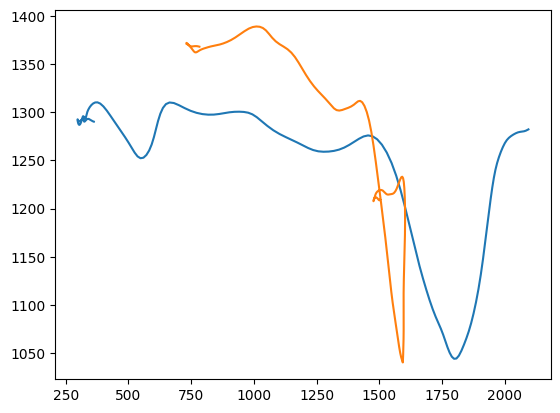

In [6]:
plt.plot(vid_1_hip[0, :], vid_1_hip[1, :])
plt.plot(vid_2_hip[0, :], vid_2_hip[1, :])

In [7]:
# seq = analyser.seq1
# window_size = 60
# stride = 30
# import math
# print('Range = ', math.ceil(((seq.shape[-1] - window_size + 1) / stride)))
# for i in range(math.ceil(((seq.shape[-1] - window_size + 1) / stride))):
#     # seq[:, :, i * stride: i * stride + window_size]
#     print('From:', i * stride, ' To: ', i * stride + window_size)

In [8]:
path, dist = dtw_path(vid_1_hip[0], vid_2_hip[0])

In [9]:
# get frames corresponding to the path pairs
s1 = np.empty((15, 2, 0))
s2 = np.empty((15, 2, 0))

for i1, i2 in path:
    s1 = np.concatenate((s1, analyser.seq1[:, :, i1].reshape(15, 2, 1)), axis=2)
    s2 = np.concatenate((s2, analyser.seq2[:, :, i2].reshape(15, 2, 1)), axis=2)

In [10]:
analyser2 = VolleyWrapper(vid1, vid2)
analyser2.seq1 = s1
analyser2.seq2 = s2

analyser2.set_window_stride_size(60, 30)

analyser2.draw_two_sequences('analyses/visual_results/alignment_dtw.mp4', fps=30)

# PCA

In [23]:
s1 = analyser.seq1
s2 = analyser.seq2

In [58]:
from sklearn. preprocessing import StandardScaler

In [63]:
s1.reshape(-1, 30)

array([[ 485.51483239,  484.3877979 ,  482.36747771, ...,  392.68306739,
         389.8933968 ,  387.65475236],
       [ 385.96241852,  384.81469274,  384.18184256, ...,  450.34366622,
         456.9248154 ,  464.02812269],
       [ 471.71696525,  479.95829784,  488.62763321, ...,  854.85588036,
         877.9419473 ,  900.22966134],
       ...,
       [1516.57926955, 1515.99731169, 1514.41876448, ..., 1489.2698482 ,
        1492.62028224, 1494.90714249],
       [1496.08255294, 1496.16584367, 1495.08593976, ..., 1336.71078176,
        1344.49523252, 1353.24081606],
       [1361.49833382, 1368.47640845, 1374.3506185 , ..., 1457.24600361,
        1456.21663963, 1455.74244042]])

In [73]:
scaler1 = StandardScaler()
s1_s = scaler1.fit_transform(s1.reshape(30, -1).T)  # not the same as s1.reshape(-1, 30)

scaler2 = StandardScaler()
s2_s = scaler2.fit_transform(s2.reshape(30, -1).T)


In [82]:
from sklearn.decomposition import PCA

pca1 = PCA(n_components=1)

s1_x = pca1.fit_transform(s1_s)

pca2 = PCA(n_components=1)
s2_x = pca2.fit_transform(s2_s)

pca1.explained_variance_ratio_, pca2.explained_variance_ratio_

(array([0.76799817]), array([0.83978717]))

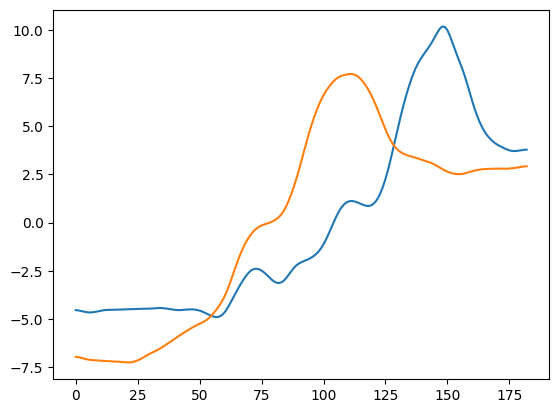

In [83]:
plt.plot(s1_x[:, 0])
plt.plot(s2_x[:, 0])

In [84]:
path, dist = dtw_path(s1_x, s2_x)

In [85]:
len(path)

302

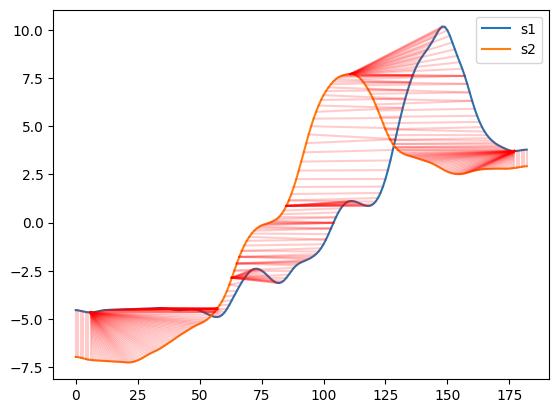

In [86]:
# plot the path
plt.plot(s1_x[:, 0], label='s1')
plt.plot(s2_x[:, 0], label='s2')
plt.legend()
for i1, i2 in path:
    plt.plot([i1, i2], [s1_x[i1, 0], s2_x[i2, 0]], 'r', alpha=0.2)